In [1]:
import sys
sys.path.insert(0, "../")

In [2]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

from src.models.resnet import ResNet
from src.utils import update_state_dict
from src.datasets.loader import get_loaders
from src.datasets import CelebA
from src.metrics import WorstGroupAccuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
ckpt = torch.load("../checkpoints/resnet18_celeba_Male_0.0/last.ckpt")
state_dict = update_state_dict(ckpt["state_dict"])

model = ResNet("resnet18", 1, False)
model.load_state_dict(state_dict)
model = model.to(device=device)

In [4]:
train_dataset = CelebA("../../datasets/celeba", "Male", 0)
train_loader = get_loaders(
    train_dataset,
    batch_size=128,
    num_workers=4,
    pin_memory=True,
)


valid_dataset = CelebA("../../datasets/celeba", "Male", 1)
valid_loader = get_loaders(
    valid_dataset,
    batch_size=128,
    num_workers=4,
    pin_memory=True,
)


test_dataset = CelebA("../../datasets/celeba", "Male", 2)
test_loader = get_loaders(
    test_dataset,
    batch_size=128,
    num_workers=4,
    pin_memory=True,
)


In [5]:
@torch.no_grad()
def validate(loader):
    wg_accuracy_metric = WorstGroupAccuracy()

    model.eval()
    for batch in tqdm(loader):
        filename = batch.pop("filename")
        batch = {k: v.to(device=device) for k, v in batch.items()}
        logits = model(batch["image"].to(device=device))
        y_true = batch["label"].float()
        if y_true.ndim < 2:
            y_true.unsqueeze_(1)

        if logits.size(1) == 2:
            y_pred = torch.softmax(logits, dim=1)
            y_pred = torch.argmax(y_pred, dim=1)
        else:
            y_pred = (torch.sigmoid(logits) >= 0.5).float()

        g = batch["group"]
        wg_accuracy_metric.update(y_pred, y_true, g)
    wg, acc_groups = wg_accuracy_metric.compute()
    return wg, acc_groups

In [6]:
model.eval()

print("Training set")
train_wg, train_acc_groups = validate(train_loader)

print("Validation set")
valid_wg, valid_acc_groups = validate(valid_loader)

print("Test set")
test_wg, test_acc_groups = validate(test_loader)

Training set


  0%|          | 0/1272 [00:00<?, ?it/s]

Validation set


  0%|          | 0/156 [00:00<?, ?it/s]

Test set


  0%|          | 0/156 [00:00<?, ?it/s]

<Axes: title={'center': 'Worst-group Accuracy (on test set)'}, ylabel='Accuracy'>

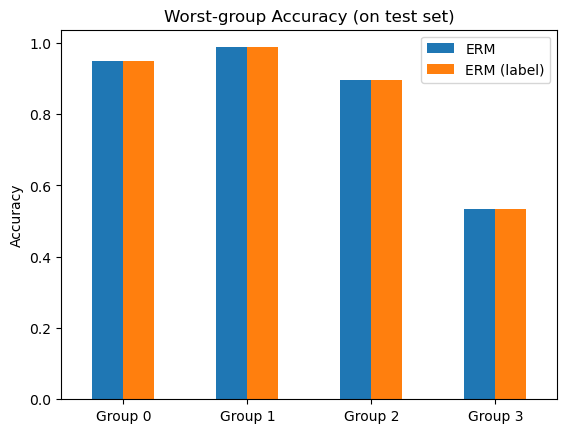

: 

In [12]:
df = pd.DataFrame(
    {
        # "Training": train_acc_groups.values(),
        # "Validation": valid_acc_groups.values(),
        "ERM": test_acc_groups.values(),
        "ERM (label)": test_acc_groups.values(),
    },
    index=[f"Group {i}" for i in range(4)],
)
df.plot(
    kind="bar", rot=0, title="Worst-group Accuracy (on test set)", ylabel="Accuracy"
)